# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# Applying SVM

## Linear SVM

### Applying Linear SVM on BOW

In [2]:
# Working with 50K points for brute force

# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data Cleaning :Deduplication

In [3]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries 
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


## Observation:-
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [10]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ..."
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...


## Prerpocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags Remove any punctuations or limited set of special characters like , or . or # etc. Check if the word is made up of english letters and is not alpha-numeric Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters) Convert the word to lowercase Remove Stopwords Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming) After which we collect the words used to describe positive and negative reviews

In [11]:
# Importing necessary libraries

from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)# To remove urls
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()# To remove numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) # To remove special characters
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)# To convert to lower case letters
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:47<00:00, 1849.73it/s]


In [14]:
# Adding a new column "Review_Text" to the "final" dataframe with the Text "preprocessed_reviews"

final["Review_Text"]=preprocessed_reviews

In [15]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...


## Sorting the data in descending order beased on Time Column

In [16]:
final=final.sort_values(by='Time',axis=0,ascending=False)

In [17]:
final.head(50)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
5259,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...,purchased product local store ny kids love qui...
1005,1089,B004FD13RW,A1BPLP0BKERV,Paul,0,0,1,1351209600,It is awesome.,"My partner is very happy with the tea, and is ...",partner happy tea feeling much better since st...
63160,68621,B005IOXBY0,A1ORVAUR5C5N8X,amondigirl,0,0,1,1351209600,WOW.....,This chocolate is amazing..I love the taste an...,chocolate amazing love taste smell chocolate f...
9513,10404,B005HI55CS,A36ERNIM0TKG3T,Donald E. Bolton,0,0,1,1351209600,Hidden Springs Maple syrup,This is one of the very finest maple syrups I ...,one finest maple syrups ordered enjoyed bought...
86066,93711,B001NZPFB0,A3318V6FJ2KIII,T. Dennis,0,0,1,1351209600,My dog enjoys it and it helps her hips.,My dog was diagnosed with hip dysplasia as a 6...,dog diagnosed hip dysplasia old puppy vet said...
30235,32932,B001P05K8Q,A3L0B5NBTQ7ZHO,Julie,0,0,1,1351209600,Great results but they stink,We originally purchased these chews from our v...,originally purchased chews veterinarian decide...
96778,105165,B005EF0HZ4,A2A5Z7LC91EFVA,Gretchen Casey,0,0,1,1351209600,Gluten Free Kid,We LOVE Lucy's cookies! The Maple Bliss are w...,love lucy cookies maple bliss wonderful bad ha...
96779,105166,B005EF0HZ4,A1JXSMYVHFPWM1,marsha m beers,0,0,0,1351209600,Disappointed,I have not been able to find the Maple flavor ...,not able find maple flavor cookies area anywhe...
39050,42397,B0014DXT5A,AZUCLRMHEBUG0,"T. HANLEY ""reader""",0,0,1,1351209600,ZipFizz liquid energy shot,Have used this for years. Gives long lasting ...,used years gives long lasting energy boost no ...
5472,5924,B00523NRVO,A2JDXKFZ0PFHKU,James W. Shondel,0,0,1,1351209600,The perfect pop!,"These lollipops are are well done, look exactl...",lollipops well done look exactly like picture ...


In [18]:
# Dropping unnecessary columns and keeping only Review_Text and Score Columns

final_df=final[['Review_Text','Score']]

In [19]:
final_df.head()

,Review_Text,Score
5259,purchased product local store ny kids love qui...,1
1005,partner happy tea feeling much better since st...,1
63160,chocolate amazing love taste smell chocolate f...,1
9513,one finest maple syrups ordered enjoyed bought...,1
86066,dog diagnosed hip dysplasia old puppy vet said...,1


In [20]:
final_df.shape

(87773, 2)

In [21]:
#Splitting the data into Features and Labels

X=final_df['Review_Text'].values
y=final_df['Score'].values

In [22]:
# Splitting the data into Training and Testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.20,random_state=3,shuffle=False) 
X_train, X_cv, y_train, y_cv= train_test_split(X_train, y_train, test_size=0.20,random_state=3,shuffle=False) 

In [23]:
# Shape of the Training and Test data

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)



(56174,) (56174,)
(14044,) (14044,)
(17555,) (17555,)


In [43]:
# Converting to BOW

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(56174, 43903) (56174,)
(14044, 43903) (14044,)
(17555, 43903) (17555,)


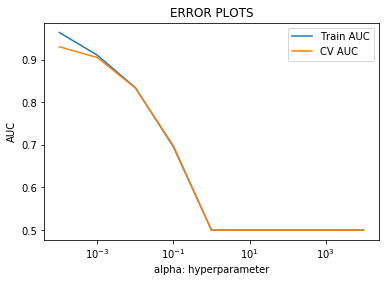

In [44]:
# Hyper parameter tuning to find best alpha
# Simple Cross validation

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]
for i in alpha:
    sgd = SGDClassifier(loss='hinge',penalty='l1',alpha=i,random_state=5,class_weight='balanced',n_jobs=-1)
    sgd.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    # Building Calibratedclassfiercv to get probabilities
    clf_sigmoid=CalibratedClassifierCV(sgd,method='sigmoid',cv=3)
    clf_sigmoid.fit(X_train_bow,y_train)
    
    y_train_pred =  clf_sigmoid.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  clf_sigmoid.predict_proba(X_cv_bow)[:,1]
    y_test_pred=clf_sigmoid.predict_proba(X_test_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc,label='Train AUC')
plt.semilogx(alpha, cv_auc,label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

 From the above plot,we can see that the best alpha is 10^-4

## Scaling the vectorized data before applying Linear SVM

In [45]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_train_bow_std=sc.fit_transform(X_train_bow)
X_cv_bow_std=sc.transform(X_cv_bow)
X_test_bow_std=sc.transform(X_test_bow)

## Building Linear SVM using best alpha with l1 regularization

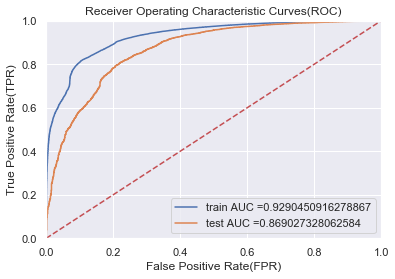

In [73]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

sgd = SGDClassifier(loss='hinge',penalty='l1',alpha=10**-4,random_state=4,class_weight='balanced',n_jobs=-1)
sgd.fit(X_train_bow_std, y_train)
clf_sigmoid=CalibratedClassifierCV(sgd,method='sigmoid',cv=3)
clf_sigmoid.fit(X_train_bow,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_l1 = roc_curve(y_train, clf_sigmoid.predict_proba(X_train_bow_std)[:,1])
test_fpr, test_tpr, thresholds_te_l1 = roc_curve(y_test, clf_sigmoid.predict_proba(X_test_bow_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


In [51]:
# we are writing our own function to predict, with defined thresould
# we will pick a threshold that will give the least fpr

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print()
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [75]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_l1, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.7316378170241612 for threshold 0.59

Train confusion matrix:

[[  922  8901]
 [ 1351 45000]]

Test confusion matrix:

[[  160  2007]
 [  371 15017]]


## Plotting confusion matrix for l1 regularization using seaborn

In [76]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

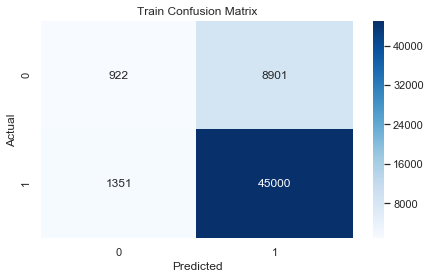

In [77]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

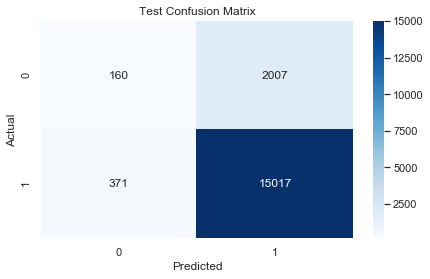

In [78]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

## Hyper parameter tuning to find best alpha using l2 regularization


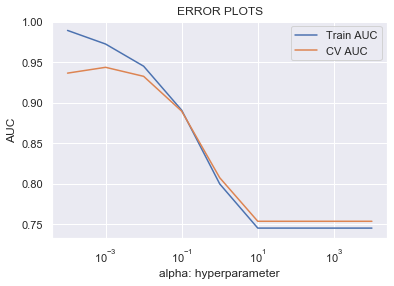

In [79]:


# Simple Cross validation

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]
for i in alpha:
    sgd = SGDClassifier(loss='hinge',penalty='l2',alpha=i,random_state=4,class_weight='balanced',n_jobs=-1)
    sgd.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    # Building Calibratedclassfiercv to get probabilities
    clf_sigmoid=CalibratedClassifierCV(sgd,method='sigmoid',cv=3)
    clf_sigmoid.fit(X_train_bow,y_train)
    
    y_train_pred =  clf_sigmoid.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  clf_sigmoid.predict_proba(X_cv_bow)[:,1]
    y_test_pred=clf_sigmoid.predict_proba(X_test_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc,label='Train AUC')
plt.semilogx(alpha, cv_auc,label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above plot,we can see that the best alpha value is 10^-3

## Building Linear SVM using best alpha with l2 regularization

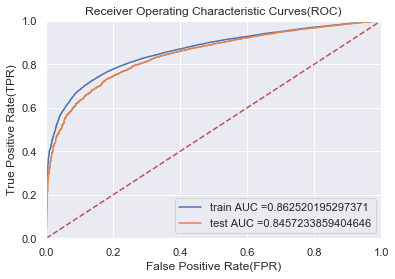

In [80]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

sgd_l2 = SGDClassifier(loss='hinge',penalty='l2',alpha=10**-3,random_state=4,class_weight='balanced',n_jobs=-1)
sgd_l2.fit(X_train_bow_std, y_train)
clf_sigmoid_l2=CalibratedClassifierCV(sgd,method='sigmoid',cv=3)
clf_sigmoid_l2.fit(X_train_bow,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_l2_bow= roc_curve(y_train, clf_sigmoid_l2.predict_proba(X_train_bow_std)[:,1])
test_fpr, test_tpr, thresholds_te_l2_bow = roc_curve(y_test, clf_sigmoid_l2.predict_proba(X_test_bow_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting Confusion Matrix for l2 regularization using seaborn

In [82]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_l2_bow, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.627569914961321 for threshold 0.838

Train confusion matrix:

[[ 6528  3295]
 [13640 32711]]

Test confusion matrix:

[[ 1335   832]
 [ 4212 11176]]


In [83]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

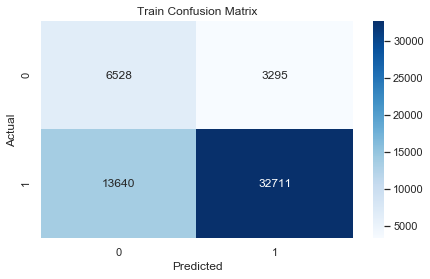

In [84]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

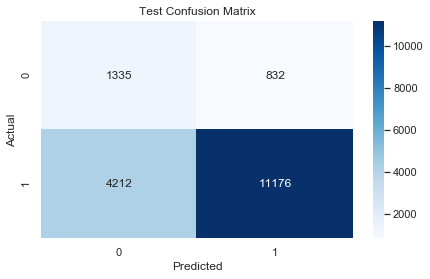

In [85]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

## Top 10 important features of positive class

In [87]:
# Calculating weights

W=sgd.coef_

In [89]:
W

array([[ 1.68579480e-09,  3.23618573e-09,  2.15745715e-09, ...,
         1.07872858e-09, -5.09010976e-09,  1.07872858e-09]])

In [90]:
# Finding the indices of the weight vector(coefficients)
Pos_Class_features=W[0].argsort()
Pos_Class_features

array([25849, 30031, 43234, ..., 16353, 22440, 16694], dtype=int64)

In [91]:
# Finding top 10 features of Positive Class
Pos_Class_features=Pos_Class_features[-10:]
Pos_Class_features

array([22136, 13843, 22456, 25568, 28181,  9975,  3545, 16353, 22440,
       16694], dtype=int64)

In [92]:
# printing the top 10 positive feature names

print(np.take(vectorizer.get_feature_names(),Pos_Class_features))

['little' 'favorite' 'loves' 'nice' 'perfect' 'delicious' 'best' 'good'
 'love' 'great']


In [93]:
features=np.take(vectorizer.get_feature_names(),Pos_Class_features)

In [94]:
# Creating a dataframe for the top 10 positive featues

Postive_features=pd.DataFrame(Pos_Class_features,columns=['Indices'])
Top_10_Positive_features=Postive_features.sort_values(by='Indices',ascending=True)

In [95]:
Top_10_Positive_features=Top_10_Positive_features.head(10)

In [96]:
Top_10_Positive_features['feature_names']=features

In [97]:
Top_10_Positive_features

,Indices,feature_names
6,3545,little
5,9975,favorite
1,13843,loves
7,16353,nice
9,16694,perfect
0,22136,delicious
8,22440,best
2,22456,good
3,25568,love
4,28181,great


## Top 10 important features of negative class

In [99]:
# finding the indices of negative class
Neg_Class_features=W[0].argsort()
Neg_Class_features

array([25849, 30031, 43234, ..., 16353, 22440, 16694], dtype=int64)

In [100]:
# Finding top 10 features of Negative Class
Neg_Class_features=Neg_Class_features[0:10]
Neg_Class_features

array([25849, 30031, 43234, 38327, 21924,  2727, 12995, 25676,  8607,
       10787], dtype=int64)

In [101]:
# printing the top 10 negative feature names

print(np.take(vectorizer.get_feature_names(),Neg_Class_features))

['not' 'product' 'would' 'taste' 'like' 'bad' 'even' 'no' 'could'
 'disappointed']


In [102]:
Neg_features=np.take(vectorizer.get_feature_names(),Neg_Class_features)

In [103]:
# Creating a dataframe for the top 10 Negative featues

Negative_features=pd.DataFrame(Neg_Class_features,columns=['Indices'])
Top_10_Negative_features=Negative_features.sort_values(by='Indices',ascending=True)

In [104]:
Top_10_Negative_features=Top_10_Negative_features.head(10)

In [105]:
Top_10_Negative_features['feature_names']=Neg_features

In [106]:
Top_10_Negative_features

,Indices,feature_names
5,2727,not
8,8607,product
9,10787,would
6,12995,taste
4,21924,like
7,25676,bad
0,25849,even
1,30031,no
3,38327,could
2,43234,disappointed


###  Applying Linear SVM on TFIDF

In [168]:
tf_idf_vect = TfidfVectorizer(max_df=0.1)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted Tfidf vectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(56174, 43872) (56174,)
(14044, 43872) (14044,)
(17555, 43872) (17555,)


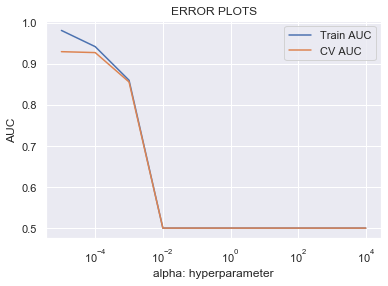

In [169]:
# Finding best alpha using simple cross validation on l1 regularization

# Simple Cross validation

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [10**-5,10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]
for i in alpha:
    sgd = SGDClassifier(loss='hinge',penalty='l1',alpha=i,random_state=4,class_weight='balanced',n_jobs=-1)
    sgd.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    # Building Calibratedclassfiercv to get probabilities
    clf_sigmoid=CalibratedClassifierCV(sgd,method='sigmoid',cv=3)
    clf_sigmoid.fit(X_train_tfidf,y_train)
    
    y_train_pred =  clf_sigmoid.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  clf_sigmoid.predict_proba(X_cv_tfidf)[:,1]
    y_test_pred=clf_sigmoid.predict_proba(X_test_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc,label='Train AUC')
plt.semilogx(alpha, cv_auc,label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the plot,we can see that the best alpha value is 10^-4

In [182]:
# Standardizing the data

sc=StandardScaler(with_mean=False)
X_train_tfidf_std=sc.fit_transform(X_train_tfidf)
X_cv_tfidf_std=sc.transform(X_cv_tfidf)
X_test_tfidf_std=sc.transform(X_test_tfidf)

## Building Linear SVM using best alpha value on l1 regularization

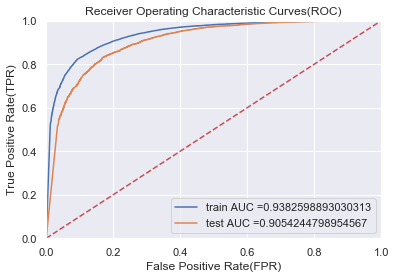

In [183]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

sgd_l1=SGDClassifier(loss='hinge',penalty='l1',alpha=10**-4,random_state=5,class_weight='balanced',n_jobs=-1)
sgd_l1.fit(X_train_tfidf_std, y_train)
clf_sigmoid_l1=CalibratedClassifierCV(sgd_l1,method='sigmoid',cv=3)
clf_sigmoid_l1.fit(X_train_tfidf,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_l1_tfidf = roc_curve(y_train, clf_sigmoid_l1.predict_proba(X_train_tfidf_std)[:,1])
test_fpr, test_tpr, thresholds_te_l1_tfidf = roc_curve(y_test, clf_sigmoid_l1.predict_proba(X_test_tfidf_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting confusion matrix for l1 regularization using seaborn

In [184]:
print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_l1_tfidf, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.7469032998834171 for threshold 0.333

Train confusion matrix:

[[ 3629  6194]
 [  732 45619]]

Test confusion matrix:

[[  577  1590]
 [  184 15204]]


In [185]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

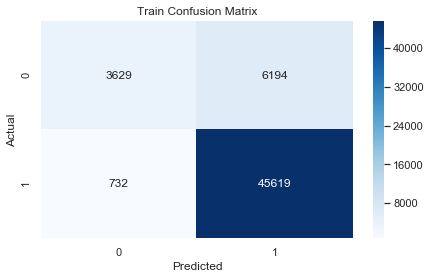

In [186]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

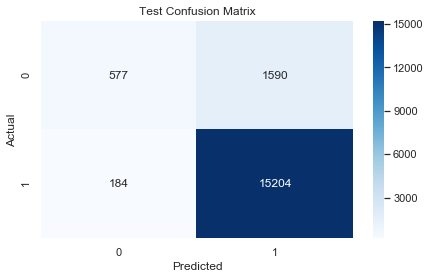

In [187]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

## Finding best alpha using simple cross validation on l2 regularization

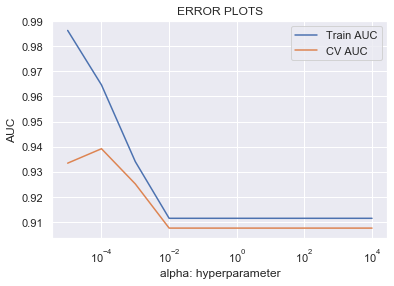

In [174]:

# Simple Cross validation

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [10**-5,10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]
for i in alpha:
    sgd = SGDClassifier(loss='hinge',penalty='l2',alpha=i,random_state=4,class_weight='balanced',n_jobs=-1)
    sgd.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    # Building Calibratedclassfiercv to get probabilities
    clf_sigmoid=CalibratedClassifierCV(sgd,method='sigmoid',cv=3)
    clf_sigmoid.fit(X_train_tfidf,y_train)
    
    y_train_pred =  clf_sigmoid.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  clf_sigmoid.predict_proba(X_cv_tfidf)[:,1]
    y_test_pred=clf_sigmoid.predict_proba(X_test_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc,label='Train AUC')
plt.semilogx(alpha, cv_auc,label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above plot,we can see that the best alpha is 10^-4

In [175]:
# Standardizing the data
sc=StandardScaler(with_mean=False)
X_train_tfidf_std=sc.fit_transform(X_train_tfidf)
X_cv_tfidf_std=sc.transform(X_cv_tfidf)
X_test_tfidf_std=sc.transform(X_test_tfidf)

## Building Linear SVM using best alpha on le regularization

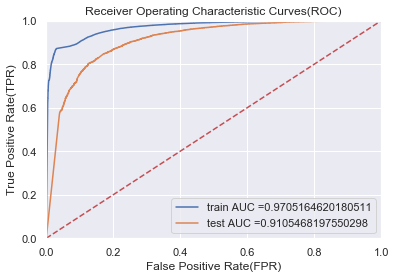

In [176]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

sgd_l2=SGDClassifier(loss='hinge',penalty='l2',alpha=10**-4,random_state=5,class_weight='balanced',n_jobs=-1)
sgd_l2.fit(X_train_tfidf_std, y_train)
clf_sigmoid_l2=CalibratedClassifierCV(sgd_l2,method='sigmoid',cv=3)
clf_sigmoid_l2.fit(X_train_tfidf,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_l2_tfidf = roc_curve(y_train, clf_sigmoid_l2.predict_proba(X_train_tfidf_std)[:,1])
test_fpr, test_tpr, thresholds_te_l2_tfidf = roc_curve(y_test, clf_sigmoid_l2.predict_proba(X_test_tfidf_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting Confusion matrix using seaborn on l2 regularization

In [177]:
print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_l2_tfidf, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.8458690933688 for threshold 0.333

Train confusion matrix:

[[ 3629  6194]
 [  732 45619]]

Test confusion matrix:

[[  577  1590]
 [  184 15204]]


In [178]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

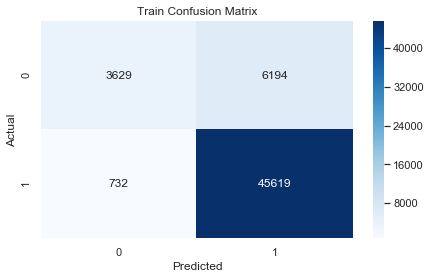

In [179]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

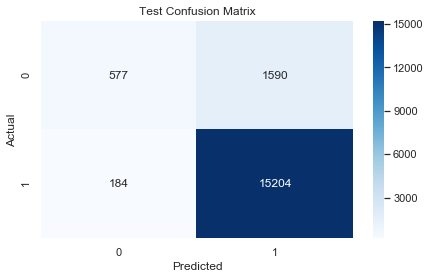

In [180]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Applying Linear SVM on AVG W2V

In [24]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [25]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [26]:
# This line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [27]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14159
sample words  ['purchased', 'product', 'local', 'store', 'ny', 'kids', 'love', 'quick', 'easy', 'meal', 'put', 'toaster', 'oven', 'toast', 'min', 'ready', 'eat', 'strongly', 'recommend', 'partner', 'happy', 'tea', 'feeling', 'much', 'better', 'since', 'starting', 'drink', 'drinking', 'hot', 'normal', 'iced', 'chilled', 'likes', 'refreshing', 'nature', 'chocolate', 'amazing', 'taste', 'smell', 'found', 'new', 'one', 'finest', 'maple', 'syrups', 'ordered', 'enjoyed', 'bought', 'fancy']


## Converting Reviews into Numerical Vectors using W2V vectors

## Algorithm: Avg W2V

In [28]:
from tqdm import tqdm
import numpy as np

## Converting Train data text

In [29]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_train = np.array(sent_vectors)


100%|███████████████████████████████████████████████████████████████████████████| 56174/56174 [02:22<00:00, 394.05it/s]


In [30]:
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

(56174, 50)
[-0.85694141 -0.13664739 -0.52166286 -0.28647949 -0.49330645 -0.20316286
  0.25656627 -0.21831172 -0.26914232  0.43936706  0.90246419 -0.03937324
 -1.16494607  0.411958   -0.51718403 -0.20663509  0.27953498  0.03252399
 -0.09669336 -0.14082019  0.21919147 -0.1324866   0.77387812  0.36416325
  0.25403223  0.8020449  -0.44436453 -0.04495023  0.45902623  0.33090509
 -0.35929251 -0.07954041 -0.22355871 -1.21360574 -0.67378736 -0.64705531
 -0.09810883 -0.57296324  0.94157182 -0.41591084 -0.01789738  0.80493173
  0.23125618  0.56810304 -0.59318574  0.43612703  0.40182196  0.52432554
  0.19941024  0.58376586]


## Converting CV data text

In [30]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [32]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)


100%|███████████████████████████████████████████████████████████████████████████| 14044/14044 [00:35<00:00, 391.34it/s]


In [33]:
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

(14044, 50)
[-0.00868092  0.12482546 -0.06428085 -0.13551033 -0.08815633 -0.03662917
 -0.06393137 -0.04194806  0.21460298  0.02336924 -0.01566597  0.01089227
 -0.44709866 -0.39601647 -0.9501891  -0.3955523   0.7263383  -1.11526084
  1.14145681  0.41045258  0.18934315 -0.32937995  0.56673983  0.3294819
  1.07023298 -0.04781089 -0.02634814  0.22544217  0.07929518  0.30435881
  0.26378417  0.21988503  0.15361213 -0.23922256  0.20548448  0.01344278
  0.23725491 -0.39087556  0.36039117 -0.38237841 -0.81252601  0.01039592
  0.16873334  0.75164821 -0.72956317  0.42936307  0.20381016  0.11717804
  0.18432727 -0.32783515]


## Converting Test data text

In [29]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [35]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [00:44<00:00, 397.06it/s]


(17555, 50)
[-0.61314294  0.15218412 -0.42650982  1.08455345 -0.43488124 -0.62102939
 -0.36386449  0.08772525  0.57265604 -0.89581314  0.59753237  0.1603457
 -0.34897162  0.43303322 -0.73302313 -0.45850564  0.810854   -0.67309645
  0.50721213 -0.23866911  0.35166439 -0.22759356  0.89957472  0.82213436
  0.34347674  0.62706743 -0.1845448   0.21662324 -0.05596618  0.38538106
  0.27074303  0.41305639  0.5659716  -0.93107748 -0.29463058  0.42340353
  0.22236924 -0.34620951 -0.06548799 -0.7087824  -0.80498775  0.68499113
  0.30611794 -0.30312737 -0.75191375 -0.5627707   0.456312    0.39780125
  0.66301847  0.16921705]


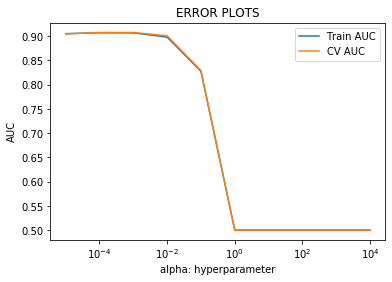

In [36]:
# Finding best alpha using simple cross validation on l1 regularization

# Simple Cross validation

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [10**-5,10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]
for i in alpha:
    sgd = SGDClassifier(loss='hinge',penalty='l1',alpha=i,random_state=4,class_weight='balanced',n_jobs=-1)
    sgd.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    # Building Calibratedclassfiercv to get probabilities
    clf_sigmoid=CalibratedClassifierCV(sgd,method='sigmoid',cv=3)
    clf_sigmoid.fit(sent_vectors_train,y_train)
    
    y_train_pred =  clf_sigmoid.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  clf_sigmoid.predict_proba(sent_vectors_cv)[:,1]
    y_test_pred=clf_sigmoid.predict_proba(sent_vectors_test)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc,label='Train AUC')
plt.semilogx(alpha, cv_auc,label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the plot,we can see that the best alpha value is between 10^-4 to 10^-2

## Building Linear SVM using best alpha and with l1 regularization

In [38]:
# Standardizing the data
from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_train_avgw2v_std=sc.fit_transform(sent_vectors_train)
X_cv_avgv2v_std=sc.transform(sent_vectors_cv)
X_test_avgw2v_std=sc.transform(sent_vectors_test)

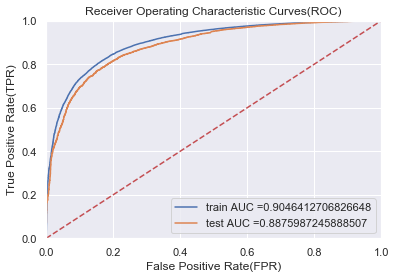

In [54]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

sgd_l1_avgw2v=SGDClassifier(loss='hinge',penalty='l1',alpha=10**-4,random_state=5,class_weight='balanced',n_jobs=-1)
sgd_l1_avgw2v.fit(X_train_avgw2v_std, y_train)
clf_sigmoid_avgw2v=CalibratedClassifierCV(sgd_l1_avgw2v,method='sigmoid',cv=3)
clf_sigmoid_avgw2v.fit(X_train_avgw2v_std,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_l1_avgw2v = roc_curve(y_train, clf_sigmoid_avgw2v.predict_proba(X_train_avgw2v_std)[:,1])
test_fpr, test_tpr, thresholds_te_l1_avgw2v = roc_curve(y_test, clf_sigmoid_avgw2v.predict_proba(X_test_avgw2v_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting Confusion matrix using seaborn :L1 regularization

In [45]:
# we are writing our own function to predict, with defined thresould
# we will pick a threshold that will give the least fpr

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print()
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [56]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_l1_avgw2v, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.6804700474399548 for threshold 0.812

Train confusion matrix:

[[ 7916  1907]
 [ 9063 37288]]

Test confusion matrix:

[[ 1594   573]
 [ 2526 12862]]


In [57]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

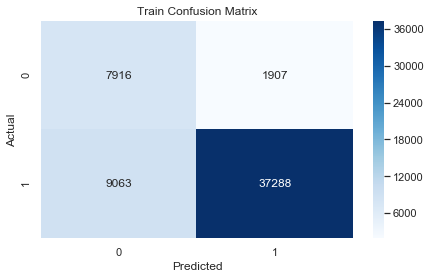

In [58]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

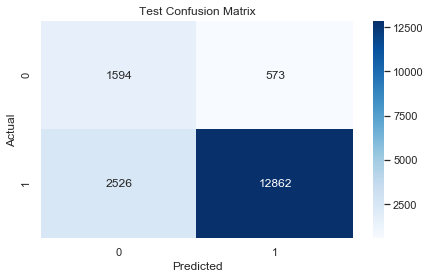

In [59]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

## Finding best alpha using simple cross validation on l2 regularization

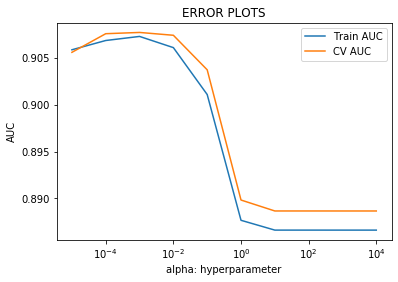

In [48]:

# Simple Cross validation

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [10**-5,10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]
for i in alpha:
    sgd = SGDClassifier(loss='hinge',penalty='l2',alpha=i,random_state=4,class_weight='balanced',n_jobs=-1)
    sgd.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    # Building Calibratedclassfiercv to get probabilities
    clf_sigmoid=CalibratedClassifierCV(sgd,method='sigmoid',cv=3)
    clf_sigmoid.fit(sent_vectors_train,y_train)
    
    y_train_pred =  clf_sigmoid.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  clf_sigmoid.predict_proba(sent_vectors_cv)[:,1]
    y_test_pred=clf_sigmoid.predict_proba(sent_vectors_test)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc,label='Train AUC')
plt.semilogx(alpha, cv_auc,label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above plot,we can see that the best alpha value is 10^-3

## Building Linear SVM using best alpha :L2 regularization

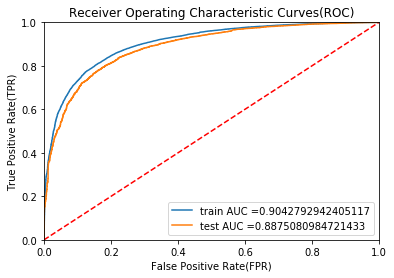

In [49]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

sgd_l2_avgw2v=SGDClassifier(loss='hinge',penalty='l2',alpha=10**-3,random_state=5,class_weight='balanced',n_jobs=-1)
sgd_l2_avgw2v.fit(X_train_avgw2v_std, y_train)
clf_sigmoid_avgw2v_l2=CalibratedClassifierCV(sgd_l2_avgw2v,method='sigmoid',cv=3)
clf_sigmoid_avgw2v_l2.fit(X_train_avgw2v_std,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_l2_avgw2v = roc_curve(y_train, clf_sigmoid_avgw2v_l2.predict_proba(X_train_avgw2v_std)[:,1])
test_fpr, test_tpr, thresholds_te_l2_avgw2v = roc_curve(y_test, clf_sigmoid_avgw2v_l2.predict_proba(X_test_avgw2v_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting confusion matrix using seaborn :L2 regularization

In [50]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_l2_avgw2v, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.6803096783247512 for threshold 0.811

Train confusion matrix:

[[ 7906  1917]
 [ 9007 37344]]

Test confusion matrix:

[[ 1590   577]
 [ 2519 12869]]


In [51]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

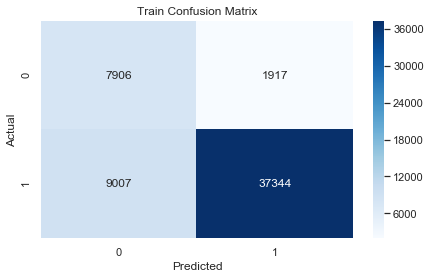

In [52]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

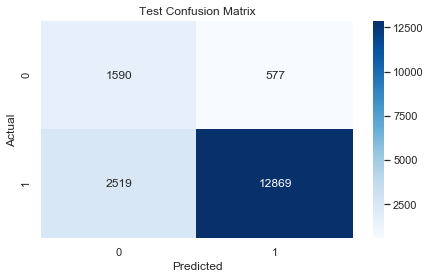

In [53]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Applying Linear SVM on TFIDF W2V

## Converting Train data to Tfidf_w2v

In [31]:
model = TfidfVectorizer(norm='l1')
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [32]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 56174/56174 [39:05<00:00, 21.89it/s]


In [33]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

In [34]:
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

(56174, 50)
[ 0.05555087  0.52846038  0.43737188  0.16975385  0.37521298  0.23284067
  0.38629947  0.07482822  0.51699539  0.34671671 -0.19278058  0.93527651
  0.74205977  0.10040747  0.21131192  0.82246656 -0.69968327  0.27244211
  0.24456564 -0.22521587 -0.39405464  0.75154461 -0.3641431   0.2392162
  1.4622244  -0.13236005 -0.06719662 -0.32084957 -0.28613947 -0.22631047
  0.72926746 -0.20853409  0.27351263 -0.21918847  0.17097185 -0.27628451
 -0.28531962 -0.18672373  0.23219461  0.14302176  0.23832268  0.88939456
  0.13467135 -0.22295139 -0.18737824 -0.16931699  0.25885428 -0.20157244
  0.57327352  0.34018229]


## Converting CV data to tfidf-w2v

In [35]:

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))# Using same dictioanry which is created for train
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 14044/14044 [09:03<00:00, 25.83it/s]


In [36]:
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)

In [37]:
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

(14044, 50)
[-0.4643838   0.1838932   0.44694286  0.47578922  1.06790883  0.10356266
 -0.33795613  0.43597067  0.63571961 -0.58418147  0.17677886  0.62413535
  0.25084531 -0.51142297  0.0155879  -0.56605573 -0.10874213 -0.5027025
  0.52136431  0.09085628 -0.49761416  0.80832004 -0.34594633  0.87131935
 -0.10229929 -0.71101551  0.49498897 -0.04004681 -0.16869587 -0.61351912
  0.0797783   0.32459439 -0.70633852 -0.56970768  0.10318027 -0.32237866
 -0.20510421 -0.19875854  0.84025711  0.31386684 -0.2634459   0.2113298
  0.15889018  0.37463593 -0.17332298  0.02125441  0.15841904  0.519788
  0.05674464 -0.71135741]


## Converting Test data to tfidf-w2v

In [38]:

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))# Using the same dictionary which is created for train
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [11:29<00:00, 19.26it/s]


In [39]:
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

In [40]:
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

(17555, 50)
[-0.00932849 -0.39672882  0.42517106  0.56613503  0.93101321  0.3413006
 -0.01585173  0.47511575  1.03780729  0.32420641  0.16163916  0.99400009
  0.05046833  0.28282098  1.01745872 -0.38726861 -0.65224907 -0.48420843
  1.14120088 -0.3261086  -0.26101166  0.47700991  0.06902985  0.01741959
 -0.02736057 -0.15250658 -0.75347015 -0.19537503 -0.34372648 -0.64508459
  0.67305169 -0.81151158 -0.67572861  0.14076057  0.16922843  0.03979991
 -0.49406752 -0.71897959 -0.29368181  0.4104256  -0.29750076  0.82150023
  0.80597662 -0.43693761 -0.32211074 -0.24085035 -0.29963999 -0.4128508
  0.46654874 -0.04096895]


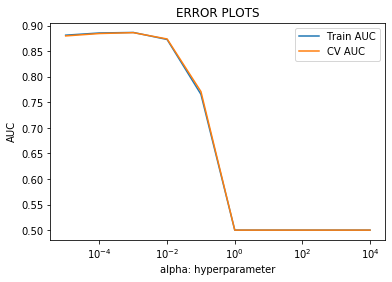

In [41]:

# Simple Cross validation

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [10**-5,10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]
for i in alpha:
    sgd_tfidfavgw2v = SGDClassifier(loss='hinge',penalty='l1',alpha=i,random_state=4,class_weight='balanced',n_jobs=-1)
    sgd_tfidfavgw2v.fit(tfidf_sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    # Building Calibratedclassfiercv to get probabilities
    clf_sigmoid=CalibratedClassifierCV(sgd_tfidfavgw2v,method='sigmoid',cv=3)
    clf_sigmoid.fit(tfidf_sent_vectors_train,y_train)
    
    y_train_pred =  clf_sigmoid.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred =  clf_sigmoid.predict_proba(tfidf_sent_vectors_cv)[:,1]
    y_test_pred=clf_sigmoid.predict_proba(tfidf_sent_vectors_test)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc,label='Train AUC')
plt.semilogx(alpha, cv_auc,label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the plot,we can see that the best alpha value is between 10^-4 to 10^-3

## Building Linear SVM with best alpha :l1 regularization

In [42]:
# Standardizing the data 
from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_train_tfidfavgw2v_std=sc.fit_transform(tfidf_sent_vectors_train)
X_cv_tfidfavgv2v_std=sc.transform(tfidf_sent_vectors_cv)
X_test_tfidfavgw2v_std=sc.transform(tfidf_sent_vectors_test)

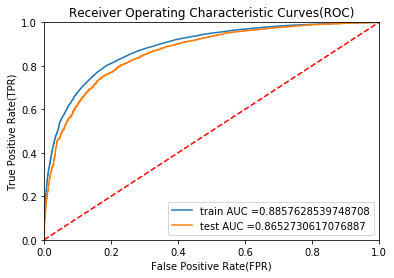

In [43]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

sgd_l1_tfidfavgw2v=SGDClassifier(loss='hinge',penalty='l1',alpha=10**-3,random_state=5,class_weight='balanced',n_jobs=-1)
sgd_l1_tfidfavgw2v.fit(X_train_tfidfavgw2v_std, y_train)
clf_sigmoid_avgw2v_l1=CalibratedClassifierCV(sgd_l1_tfidfavgw2v,method='sigmoid',cv=3)
clf_sigmoid_avgw2v_l1.fit(X_train_tfidfavgw2v_std,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_l1_tfidfavgw2v = roc_curve(y_train, clf_sigmoid_avgw2v_l1.predict_proba(X_train_tfidfavgw2v_std)[:,1])
test_fpr, test_tpr, thresholds_te_l1_tfidfavgw2v = roc_curve(y_test, clf_sigmoid_avgw2v_l1.predict_proba(X_test_tfidfavgw2v_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting confusion matrices using seaborn : l1 regularization

In [65]:
print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_l1_tfidfavgw2v, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.6523235051703363 for threshold 0.815

Train confusion matrix:

[[ 7631  2192]
 [10412 35939]]

Test confusion matrix:

[[ 1484   683]
 [ 2829 12559]]


In [66]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

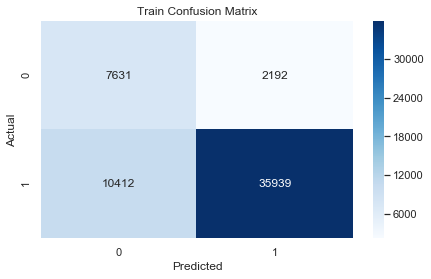

In [67]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

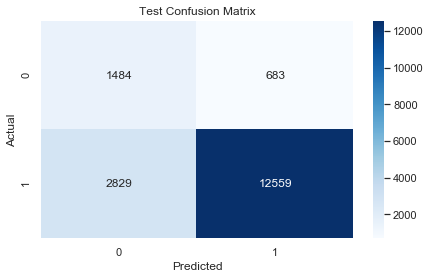

In [68]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

## Converting Train data to Tfidf_w2v :l2 regularization

In [48]:
model = TfidfVectorizer(norm='l2')
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [49]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 56174/56174 [41:00<00:00, 22.83it/s]


In [50]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

In [51]:
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

(56174, 50)
[ 0.05555087  0.52846038  0.43737188  0.16975385  0.37521298  0.23284067
  0.38629947  0.07482822  0.51699539  0.34671671 -0.19278058  0.93527651
  0.74205977  0.10040747  0.21131192  0.82246656 -0.69968327  0.27244211
  0.24456564 -0.22521587 -0.39405464  0.75154461 -0.3641431   0.2392162
  1.4622244  -0.13236005 -0.06719662 -0.32084957 -0.28613947 -0.22631047
  0.72926746 -0.20853409  0.27351263 -0.21918847  0.17097185 -0.27628451
 -0.28531962 -0.18672373  0.23219461  0.14302176  0.23832268  0.88939456
  0.13467135 -0.22295139 -0.18737824 -0.16931699  0.25885428 -0.20157244
  0.57327352  0.34018229]


## Converting CV data to tfidf-w2v

In [52]:

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 14044/14044 [09:46<00:00, 23.93it/s]


In [53]:
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)

In [54]:
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

(14044, 50)
[-0.4643838   0.1838932   0.44694286  0.47578922  1.06790883  0.10356266
 -0.33795613  0.43597067  0.63571961 -0.58418147  0.17677886  0.62413535
  0.25084531 -0.51142297  0.0155879  -0.56605573 -0.10874213 -0.5027025
  0.52136431  0.09085628 -0.49761416  0.80832004 -0.34594633  0.87131935
 -0.10229929 -0.71101551  0.49498897 -0.04004681 -0.16869587 -0.61351912
  0.0797783   0.32459439 -0.70633852 -0.56970768  0.10318027 -0.32237866
 -0.20510421 -0.19875854  0.84025711  0.31386684 -0.2634459   0.2113298
  0.15889018  0.37463593 -0.17332298  0.02125441  0.15841904  0.519788
  0.05674464 -0.71135741]


## Converting Test data to tfidf-w2v

In [55]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [11:19<00:00, 25.83it/s]


In [56]:
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

In [57]:
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

(17555, 50)
[-0.00932849 -0.39672882  0.42517106  0.56613503  0.93101321  0.3413006
 -0.01585173  0.47511575  1.03780729  0.32420641  0.16163916  0.99400009
  0.05046833  0.28282098  1.01745872 -0.38726861 -0.65224907 -0.48420843
  1.14120088 -0.3261086  -0.26101166  0.47700991  0.06902985  0.01741959
 -0.02736057 -0.15250658 -0.75347015 -0.19537503 -0.34372648 -0.64508459
  0.67305169 -0.81151158 -0.67572861  0.14076057  0.16922843  0.03979991
 -0.49406752 -0.71897959 -0.29368181  0.4104256  -0.29750076  0.82150023
  0.80597662 -0.43693761 -0.32211074 -0.24085035 -0.29963999 -0.4128508
  0.46654874 -0.04096895]


## Finding best alpha value using simple cross validation :l2 regularization

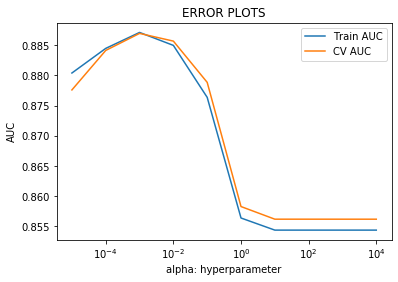

In [58]:

# Simple Cross validation

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [10**-5,10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]
for i in alpha:
    sgd_tfidfavgw2v_l2 = SGDClassifier(loss='hinge',penalty='l2',alpha=i,random_state=4,class_weight='balanced',n_jobs=-1)
    sgd_tfidfavgw2v_l2.fit(tfidf_sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    # Building Calibratedclassfiercv to get probabilities
    clf_sigmoid_l2=CalibratedClassifierCV(sgd_tfidfavgw2v_l2,method='sigmoid',cv=3)
    clf_sigmoid_l2.fit(tfidf_sent_vectors_train,y_train)
    
    y_train_pred =  clf_sigmoid_l2.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred =  clf_sigmoid_l2.predict_proba(tfidf_sent_vectors_cv)[:,1]
    y_test_pred=clf_sigmoid_l2.predict_proba(tfidf_sent_vectors_test)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.semilogx(alpha, train_auc,label='Train AUC')
plt.semilogx(alpha, cv_auc,label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the plot,we can see that the best alpha value is 10^-3

## Building Linear SVM using best alpha :L2 regularization

In [59]:
# Standardizing the data

sc=StandardScaler(with_mean=False)
X_train_tfidfavgw2v_std=sc.fit_transform(tfidf_sent_vectors_train)
X_cv_tfidfavgv2v_std=sc.transform(tfidf_sent_vectors_cv)
X_test_tfidfavgw2v_std=sc.transform(tfidf_sent_vectors_test)

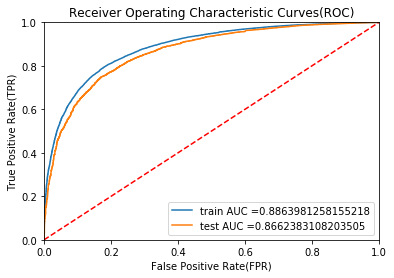

In [60]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

sgd_l2_tfidfavgw2v=SGDClassifier(loss='hinge',penalty='l2',alpha=10**-3,random_state=5,class_weight='balanced',n_jobs=-1)
sgd_l2_tfidfavgw2v.fit(X_train_tfidfavgw2v_std, y_train)
clf_sigmoid_avgw2v_l2=CalibratedClassifierCV(sgd_l2_tfidfavgw2v,method='sigmoid',cv=3)
clf_sigmoid_avgw2v_l2.fit(X_train_tfidfavgw2v_std,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_l2_tfidfavgw2v = roc_curve(y_train, clf_sigmoid_avgw2v_l2.predict_proba(X_train_tfidfavgw2v_std)[:,1])
test_fpr, test_tpr, thresholds_te_l2_tfidfavgw2v = roc_curve(y_test, clf_sigmoid_avgw2v_l2.predict_proba(X_test_tfidfavgw2v_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


# Plotting confusion matrices using seaborn: L2 regularization

In [61]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_l2_tfidfavgw2v, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.6523235051703363 for threshold 0.815

Train confusion matrix:

[[ 7625  2198]
 [10400 35951]]

Test confusion matrix:

[[ 1483   684]
 [ 2821 12567]]


In [62]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

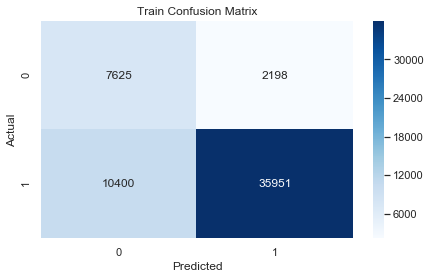

In [63]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

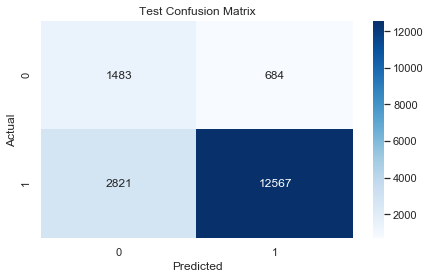

In [64]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

## RBF SVM

### Applying RBF SVM on BOW

In [72]:
# Working with 50K points for brute force

# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data Cleaning :Deduplication

In [73]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [74]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [75]:
#Deduplication of entries 
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(19354, 10)

In [76]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.77

In [77]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


## Observation:-
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [78]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [79]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(19354, 10)


1    16339
0     3015
Name: Score, dtype: int64

In [80]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
8696,9527,B00005V3DC,A8KY7S48EW7LW,"A. Daly ""AD""",0,0,1,1350172800,The Best Cleansing Tea I've Ever Had,I've used this brand for years. If you're feel...


## Prerpocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags Remove any punctuations or limited set of special characters like , or . or # etc. Check if the word is made up of english letters and is not alpha-numeric Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters) Convert the word to lowercase Remove Stopwords Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming) After which we collect the words used to describe positive and negative reviews

In [81]:
# Importing necessary libraries

from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [82]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [83]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)# To remove urls
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()# To remove numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) # To remove special characters
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)# To convert to lower case letters
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 19354/19354 [00:09<00:00, 2122.36it/s]


In [84]:
# Adding a new column "Review_Text" to the "final" dataframe with the Text "preprocessed_reviews"

final["Review_Text"]=preprocessed_reviews

In [85]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...


## Sorting the data in descending order beased on Time Column

In [86]:
final=final.sort_values(by='Time',axis=0,ascending=False)

In [87]:
final.head(50)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
5259,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...,purchased product local store ny kids love qui...
15069,16426,B007TJGZ54,A29BJSTYH9W3JI,Harry,0,0,1,1351209600,super coffee,Great coffee and so easy to brew. This coffee...,great coffee easy brew coffee great aroma good...
7620,8322,B003VXFK44,A3GFZIL1E0Z5V8,bloomen1,0,0,1,1351209600,Rodeo Drive is Crazy Good Coffee!,Rodeo Drive is my absolute favorite and I'm re...,rodeo drive absolute favorite ready order find...
6548,7178,B004OQLIHK,AKHQMSUORSA91,Pen Name,0,0,1,1351209600,Delicious!,I have ordered these raisins multiple times. ...,ordered raisins multiple times always great ar...
7156,7821,B000HB9TLI,A353IAF5Y1XE53,"J. RIGOR ""shop mama""",0,0,0,1351209600,Don't like the taste,I do not like sour taste and this has a sour k...,not like sour taste sour kind taste not like s...
5472,5924,B00523NRVO,A2JDXKFZ0PFHKU,James W. Shondel,0,0,1,1351209600,The perfect pop!,"These lollipops are are well done, look exactl...",lollipops well done look exactly like picture ...
8731,9564,B001EQ5IPQ,AA2104NO2VE8H,Lakshminarayan Iyer,0,0,0,1351209600,Extremely dissapointed,"Hi,<br />I am very disappointed with the past ...",hi disappointed past shipment received one coc...
9513,10404,B005HI55CS,A36ERNIM0TKG3T,Donald E. Bolton,0,0,1,1351209600,Hidden Springs Maple syrup,This is one of the very finest maple syrups I ...,one finest maple syrups ordered enjoyed bought...
1005,1089,B004FD13RW,A1BPLP0BKERV,Paul,0,0,1,1351209600,It is awesome.,"My partner is very happy with the tea, and is ...",partner happy tea feeling much better since st...
19181,20930,B001L1MKLY,A38XYFHXEUNUW6,bleaufire,0,0,1,1351209600,Yummy & Subtle,Just made my first pot of this wonderful coffe...,made first pot wonderful coffee simply delish ...


In [125]:
# Dropping unnecessary columns and keeping only Review_Text and Score Columns

final_df=final[['Review_Text','Score']]

In [126]:
final_df.head()

,Review_Text,Score
5259,purchased product local store ny kids love qui...,1
15069,great coffee easy brew coffee great aroma good...,1
7620,rodeo drive absolute favorite ready order find...,1
6548,ordered raisins multiple times always great ar...,1
7156,not like sour taste sour kind taste not like s...,0


In [127]:
final_df.shape

(19354, 2)

In [128]:
#Splitting the data into Features and Labels

X=final_df['Review_Text'].values
y=final_df['Score'].values

In [129]:
# Splitting the data into Training and Testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.20,random_state=3,shuffle=False) 
X_train, X_cv, y_train, y_cv= train_test_split(X_train, y_train, test_size=0.20,random_state=3,shuffle=False) 

In [130]:
# Shape of the Training and Test data

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)



(12386,) (12386,)
(3097,) (3097,)
(3871,) (3871,)


In [23]:
# Converting to BOW

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,max_features=500)
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(12386, 500) (12386,)
(3097, 500) (3097,)
(3871, 500) (3871,)


## Hyperparameter tuning to find best "C" and 'gamma"' using RandomizedSearchCV

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
# Assigning values to the parameters
C=[10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
Gamma=[10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
params_grid=dict(C=C,gamma=Gamma)

In [25]:
params_grid

{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [26]:
# Estimator
svm=SVC(kernel='rbf',class_weight='balanced',random_state=3)

In [27]:
# Building RandomizedsSearchCV

svm_RandomCV=RandomizedSearchCV(svm,params_grid,cv=5,n_iter=10,scoring='roc_auc',n_jobs=-1)
svm_RandomCV.fit(X_train_bow,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=3, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                              100, 1000],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100, 1000]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=0)

In [28]:
# Finding best parameters
svm_RandomCV.best_params_

{'gamma': 0.0001, 'C': 100}

In [29]:
# Finding best estimator
svm_RandomCV.best_estimator_

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=3, shrinking=True, tol=0.001,
    verbose=False)

In [31]:
# finding best score
svm_RandomCV.best_score_

0.8936311372733478

## Building SVM using best parameters

In [32]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_train_bow_std=sc.fit_transform(X_train_bow)
X_cv_bow_std=sc.transform(X_cv_bow)
X_test_bow_std=sc.transform(X_test_bow)

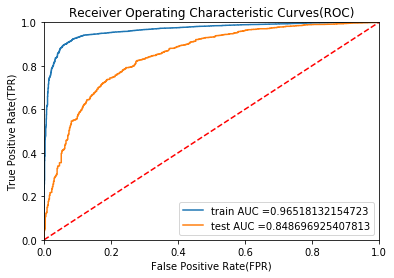

In [42]:
from sklearn.calibration import CalibratedClassifierCV
svm=SVC(C=100,gamma=0.0001,class_weight='balanced',random_state=3,kernel='rbf')
svm.fit(X_train_bow_std,y_train)
clf_sigmoid=CalibratedClassifierCV(svm,method='sigmoid',cv=3)
clf_sigmoid.fit(X_train_bow_std,y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  clf_sigmoid.predict_proba(X_train_bow_std)[:,1]
y_cv_pred =  clf_sigmoid.predict_proba(X_cv_bow_std)[:,1]
y_test_pred=clf_sigmoid.predict_proba(X_test_bow_std)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, clf_sigmoid.predict_proba(X_train_bow_std)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, clf_sigmoid.predict_proba(X_test_bow_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()



## Plotting confusion matrices usng seaborn

In [36]:
# we are writing our own function to predict, with defined thresould
# we will pick a threshold that will give the least fpr

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print()
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [44]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.8439032122473625 for threshold 0.728

Train confusion matrix:

[[1856  173]
 [ 802 9555]]

Test confusion matrix:

[[ 342  223]
 [ 382 2924]]


In [45]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

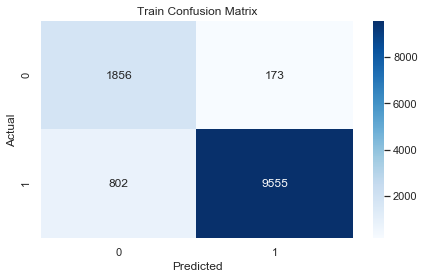

In [46]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

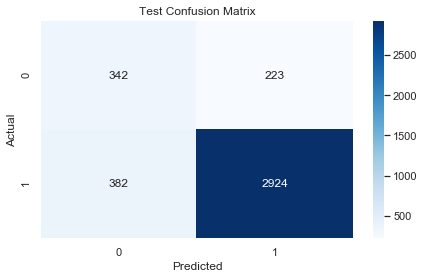

In [47]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Applying RBF SVM on TFIDF

In [54]:
tf_idf_vect = TfidfVectorizer(min_df=10,max_features=500,norm='l1')
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted Tfidf vectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(12386, 500) (12386,)
(3097, 500) (3097,)
(3871, 500) (3871,)


## Hyperparameter tuning to find best "C" and 'gamma"' using RandomizedSearchCV

In [55]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
# Assigning values to the parameters
C=[10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
Gamma=[10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
params_grid=dict(C=C,gamma=Gamma)

In [57]:
# Estimator
svm_tfidf=SVC(kernel='rbf',class_weight='balanced',random_state=4)

In [58]:
# Building RandomizedsSearchCV

svm_RandomCV=RandomizedSearchCV(svm_tfidf,params_grid,cv=5,scoring='roc_auc',n_jobs=-1)
svm_RandomCV.fit(X_train_tfidf,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=4, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                              100, 1000],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100, 1000]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=0)

In [59]:
## Finding best parameters
svm_RandomCV.best_params_

{'gamma': 10, 'C': 10}

In [60]:
# Finding best score
svm_RandomCV.best_score_

0.9011546863851737

## Building SVM with best "C" and "gamma" :l1 regularized tfidf vectors

In [61]:
# Standardizing the data
from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_train_tfidf_std=sc.fit_transform(X_train_tfidf)
X_cv_tfidf_std=sc.transform(X_cv_tfidf)
X_test_tfidf_std=sc.transform(X_test_tfidf)

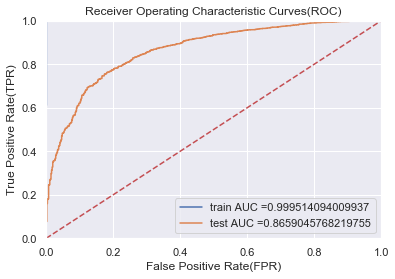

In [62]:
from sklearn.calibration import CalibratedClassifierCV
svm_tfidf=SVC(C=10,gamma=10,class_weight='balanced',random_state=5,kernel='rbf')
svm_tfidf.fit(X_train_tfidf_std,y_train)
clf_sigmoid=CalibratedClassifierCV(svm_tfidf,method='sigmoid',cv=3)
clf_sigmoid.fit(X_train_tfidf,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_tfidf = roc_curve(y_train, clf_sigmoid.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds_te_tfidf = roc_curve(y_test, clf_sigmoid.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()



## Plotting confusion matrices using seaborn

In [63]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_tfidf, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.9979532560436193 for threshold 0.474

Train confusion matrix:

[[ 1983    46]
 [  148 10209]]

Test confusion matrix:

[[ 225  340]
 [ 126 3180]]


In [64]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

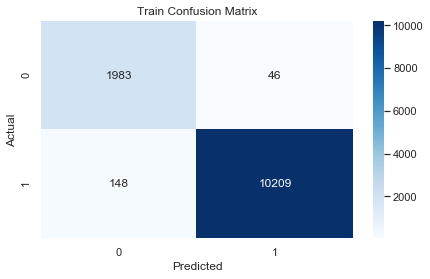

In [65]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

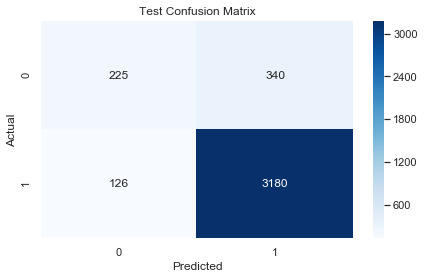

In [66]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

In [33]:
# Vectorizing using l2 regularization
tf_idf_vect = TfidfVectorizer(min_df=10,max_features=500,norm='l2')
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted Tfidf vectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(12386, 500) (12386,)
(3097, 500) (3097,)
(3871, 500) (3871,)


## Hyperparameter tuning using RandomizedSearchCV

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
# Assigning values to the parameters
C=[10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
Gamma=[10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
params_grid=dict(C=C,gamma=Gamma)

In [35]:
params_grid

{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [38]:
# Estimator
svm=SVC(kernel='rbf',class_weight='balanced',random_state=4)

In [41]:
# Building RandomizedsSearchCV

svm_RandomCV=RandomizedSearchCV(svm,params_grid,cv=5,scoring='roc_auc',n_jobs=-1)
svm_RandomCV.fit(X_train_tfidf,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=4, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                              100, 1000],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100, 1000]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=0)

In [42]:
# finding best parameters
svm_RandomCV.best_params_

{'gamma': 1, 'C': 1}

In [43]:
# finding best score
svm_RandomCV.best_score_

0.9111624958303866

In [44]:
# Standardizing the data
from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_train_tfidf_std=sc.fit_transform(X_train_tfidf)
X_cv_tfidf_std=sc.transform(X_cv_tfidf)
X_test_tfidf_std=sc.transform(X_test_tfidf)

## Building svm with best hyperparameters of tfidf vectorized data

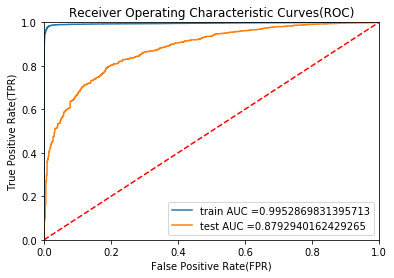

In [48]:
from sklearn.calibration import CalibratedClassifierCV
svm=SVC(C=1,gamma=1,class_weight='balanced',random_state=4,kernel='rbf')
svm.fit(X_train_tfidf_std,y_train)
clf_sigmoid=CalibratedClassifierCV(svm,method='sigmoid',cv=3)
clf_sigmoid.fit(X_train_tfidf,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_train_pred =  clf_sigmoid.predict_proba(X_train_tfidf)[:,1]
y_cv_pred =  clf_sigmoid.predict_proba(X_cv_tfidf)[:,1]
y_test_pred=clf_sigmoid.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, thresholds_tr_tfidf = roc_curve(y_train, clf_sigmoid.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds_te_tfidf = roc_curve(y_test, clf_sigmoid.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()



## Plotting confusion matrices using seaborn

In [50]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_tfidf, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.9693755501299516 for threshold 0.543

Train confusion matrix:

[[ 2005    24]
 [  197 10160]]

Test confusion matrix:

[[ 261  304]
 [ 165 3141]]


In [51]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

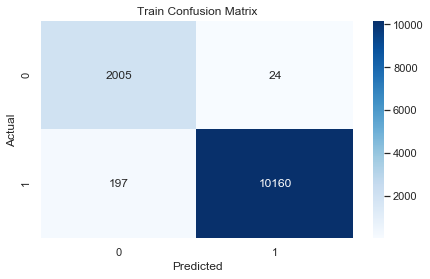

In [52]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

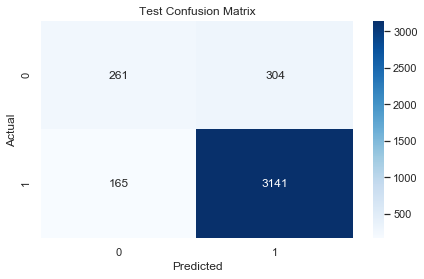

In [53]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Applying RBF SVM on AVG W2V

In [131]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

## Training W2V Model

In [132]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [133]:
# This line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [134]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6570
sample words  ['purchased', 'product', 'local', 'store', 'ny', 'kids', 'love', 'quick', 'easy', 'meal', 'put', 'toaster', 'oven', 'toast', 'min', 'ready', 'eat', 'strongly', 'recommend', 'great', 'coffee', 'brew', 'aroma', 'good', 'last', 'drop', 'actually', 'like', 'brands', 'way', 'taste', 'rodeo', 'drive', 'absolute', 'favorite', 'order', 'find', 'not', 'know', 'discontinuing', 'arrived', 'fast', 'ordered', 'raisins', 'multiple', 'times', 'always', 'arrive', 'timely', 'go']


## Converting Reviews into Numerical Vectors using W2V vectors

## Algorithm: Avg W2V

In [135]:
from tqdm import tqdm
import numpy as np

## Converting Train data text

In [72]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_train = np.array(sent_vectors)


100%|███████████████████████████████████████████████████████████████████████████| 12386/12386 [00:17<00:00, 650.15it/s]


In [73]:
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

(12386, 50)
[-0.39899976 -0.42470663 -0.17959987 -0.20735118  0.17312569 -0.00747477
 -0.81108985  0.51945608 -0.269024   -0.62159606 -0.51563002  0.04208817
  0.09381818 -0.01771061 -0.40125174 -0.99296702  0.43370454 -0.29822122
  0.12374908 -0.29838034 -0.81951975 -0.51943341  0.14580053 -0.16142554
  0.152164   -0.01185172  0.15737828 -0.41734608  0.03230124  0.18701634
 -0.25929636  0.17427883  0.70898706  0.3075214  -0.08031523 -0.00339332
  0.00524805 -0.48780171 -0.35814989  0.21481023 -0.30030237  0.18630382
 -0.22601221 -0.15542071  0.14238429  0.29866654 -0.09499984  0.14794446
 -0.42260221 -0.15193123]


## Converting CV data text

In [136]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [75]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)


100%|█████████████████████████████████████████████████████████████████████████████| 3097/3097 [00:04<00:00, 646.60it/s]


In [76]:
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

(3097, 50)
[-0.44305216 -0.22941537 -0.29847189 -0.27250522  0.01393468  0.2656699
 -1.00188365  0.21997421 -0.15184303 -0.75552021 -0.63786174 -0.02153881
  0.15680204  0.13317102 -0.2306442  -1.21067955  0.30422871  0.04718203
  0.36660176 -0.01528269 -0.98740632 -0.41417003  0.40825907 -0.33064589
  0.2176389  -0.0276579  -0.13066753 -0.21038551  0.11330862  0.42128073
 -0.21562985  0.11068845  0.03985291  0.27519356 -0.12396651  0.02408897
 -0.19760701 -0.51941474 -0.45532634 -0.13781395  0.05557434  0.36451439
 -0.42471828  0.15081981  0.38464281  0.67871875 -0.36997264 -0.00386335
 -0.61079133  0.19110693]


## Converting Test data text

In [137]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [78]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|█████████████████████████████████████████████████████████████████████████████| 3871/3871 [00:06<00:00, 572.81it/s]


(3871, 50)
[-3.66810084e-01 -4.11589404e-01 -3.31223817e-01 -3.29029058e-01
  2.32102827e-02  4.16471422e-03 -7.24723124e-01  3.97577754e-01
 -3.26378038e-01 -6.28719546e-01 -5.35002873e-01 -5.77668305e-04
  3.21769579e-01  1.51377672e-01 -8.47079354e-02 -8.92707417e-01
  6.69364460e-01 -2.45656959e-01  1.44963818e-01 -1.16118639e-01
 -8.46109009e-01 -3.54067454e-01  1.23121403e-01 -1.89318364e-01
  3.75702845e-01  4.26835819e-03 -1.86541260e-01 -2.28663053e-01
  6.84393628e-02  2.13530038e-01 -2.34984657e-01  3.71476851e-02
  2.87104845e-01  1.66036974e-01 -3.72694321e-02  9.54457932e-02
 -2.65550505e-01 -5.01488418e-01 -2.82992194e-01 -6.22278945e-02
 -4.94457267e-02  1.47332746e-01 -1.94103497e-01 -3.46696118e-02
  2.37198557e-01  4.66516976e-01 -1.01958663e-01  9.41668447e-02
 -3.12610514e-01  7.85687435e-02]


## Hyperparameter tuning to find best C and gamma

In [79]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
# Assigning values to the parameters
C=[10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
Gamma=[10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
params_grid=dict(C=C,gamma=Gamma)

In [80]:
# Estimator
svm=SVC(kernel='rbf',class_weight='balanced',random_state=6)

In [84]:
# Building RandomizedsSearchCV

svm_RandomCV=RandomizedSearchCV(svm,params_grid,cv=5,scoring='roc_auc',n_jobs=-1)
svm_RandomCV.fit(sent_vectors_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=6, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                              100, 1000],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100, 1000]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=0)

In [85]:
## Finding best parameters
svm_RandomCV.best_params_

{'gamma': 0.001, 'C': 100}

In [86]:
## Finding best score
svm_RandomCV.best_score_

0.8630035901783857

## Building svm with best parameters

In [87]:
# Standardizing the data
from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_train_avgw2v_std=sc.fit_transform(sent_vectors_train)
X_cv_avgv2v_std=sc.transform(sent_vectors_cv)
X_test_avgw2v_std=sc.transform(sent_vectors_test)

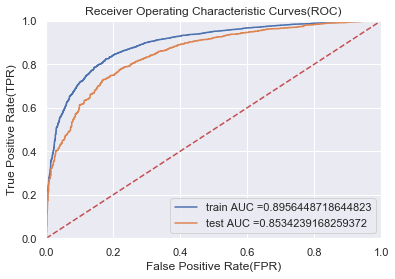

In [88]:
from sklearn.calibration import CalibratedClassifierCV
svm_avgw2v=SVC(C=100,gamma=0.001,class_weight='balanced',random_state=6,kernel='rbf')
svm_avgw2v.fit(X_train_avgw2v_std,y_train)
clf_sigmoid_avgw2v=CalibratedClassifierCV(svm_avgw2v,method='sigmoid',cv=3)
clf_sigmoid_avgw2v.fit(X_train_avgw2v_std,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_train_pred =  clf_sigmoid_avgw2v.predict_proba(X_train_avgw2v_std)[:,1]
y_cv_pred =  clf_sigmoid_avgw2v.predict_proba(X_cv_avgv2v_std)[:,1]
y_test_pred=clf_sigmoid_avgw2v.predict_proba(X_test_avgw2v_std)[:,1]

train_fpr, train_tpr, thresholds_tr_avgw2v = roc_curve(y_train, clf_sigmoid_avgw2v.predict_proba(X_train_avgw2v_std)[:,1])
test_fpr, test_tpr, thresholds_te_avgw2v = roc_curve(y_test, clf_sigmoid_avgw2v.predict_proba(X_test_avgw2v_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()



## Plotting Confusion matrices using seaborn

In [89]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_avgw2v, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.677459829479404 for threshold 0.796

Train confusion matrix:

[[1668  361]
 [1822 8535]]

Test confusion matrix:

[[ 423  142]
 [ 668 2638]]


In [90]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

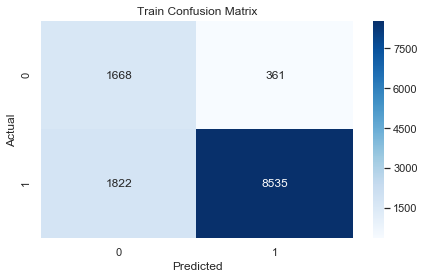

In [91]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

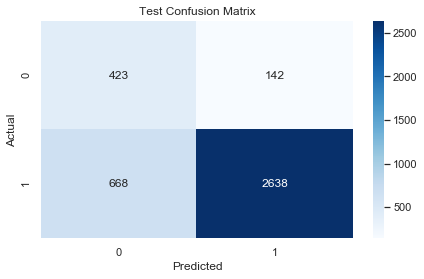

In [92]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Applying RBF SVM on TFIDF W2V

## Converting Train data to Tfidf_w2v

In [138]:
model = TfidfVectorizer(norm='l1')
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [139]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 12386/12386 [02:36<00:00, 79.29it/s]


In [140]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

In [141]:
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

(12386, 50)
[ 0.11643651  0.39536964 -0.0530198   0.16290728  0.20536834  0.14692994
  0.24158337  0.05094466  0.19358289  0.52047954 -0.14585931  0.37150199
  0.35628069 -0.33740758 -0.01607318  0.19458248 -0.46884032 -0.19191344
  0.01676795 -0.27903894 -0.48430972  0.05530848 -0.51106722 -0.113332
  0.70294862 -0.18299098  0.03513861  0.58015667  0.62787731 -0.58307391
  0.13924072 -0.25950388  0.09647588  0.1116873   0.1284859  -0.10742175
 -0.16562855 -0.23564665  0.60271152  0.46148283  0.28018811  0.1443099
 -0.13898335 -0.06628986 -0.05424743 -0.56052057 -0.39265422  0.20409699
 -0.28245144 -0.30530048]


## Converting CV data to tfidf-w2v

In [142]:

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 3097/3097 [00:38<00:00, 80.04it/s]


In [143]:
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)

In [144]:
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

(3097, 50)
[ 2.86835735e-02  6.25643688e-02 -2.01316012e-01  4.15547875e-01
  5.27245098e-01  2.96048830e-01  3.77065890e-01 -8.53473769e-02
  3.35322017e-01  3.90092530e-01  1.42579404e-03  3.96980453e-01
  3.96202936e-01 -3.91842478e-01  9.14573741e-02 -2.71079298e-04
 -4.81939186e-01 -1.10106992e-01 -3.11308559e-01 -7.35095379e-01
 -6.10057446e-01 -2.66292755e-01 -4.73474201e-01 -3.78349735e-01
  6.06830822e-01 -3.76247307e-01  3.36215249e-01  8.18962534e-01
  5.11015868e-01 -4.02330560e-01 -1.48253234e-01 -5.24394526e-01
  4.00624950e-01  3.57901851e-01  1.43367787e-01 -7.66752963e-02
 -2.38684907e-01 -8.92449389e-02  7.37591458e-01  4.66622706e-01
  9.54773821e-02  1.35054988e-01  1.76156798e-01  1.14197967e-01
  2.95250708e-01 -5.69705591e-01 -4.45878273e-01  3.15291635e-01
 -4.92610181e-01 -1.98317685e-01]


## Converting Test data to tfidf-w2v

In [145]:

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 3871/3871 [00:53<00:00, 72.68it/s]


In [146]:
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

In [147]:
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

(3871, 50)
[ 0.04492012  0.21316705 -0.0805498   0.15639912  0.29786996  0.14676172
  0.27155098 -0.02393968  0.31856494  0.26794585 -0.07233571  0.4923222
  0.23294063 -0.44642958 -0.03451912  0.13422572 -0.2055286  -0.10559914
  0.00923976 -0.33637306 -0.50468453 -0.05774854 -0.57717958 -0.13493992
  0.55134049 -0.43052366 -0.10191325  0.60846588  0.46457978 -0.33302172
 -0.08674506 -0.36480126  0.10138137  0.13168604 -0.04264327 -0.15357452
 -0.04109781 -0.25703109  0.56767145  0.52045058  0.29124309  0.08683082
 -0.08734742  0.16191754 -0.06495702 -0.47813171 -0.38656445  0.04897871
 -0.27700017 -0.28389473]


## Hyperparameter tuning to find best "C" and "gamma"

In [148]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
# Assigning values to the parameters
C=[10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
Gamma=[10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
params_grid=dict(C=C,gamma=Gamma)

In [149]:
# Estimator
svm=SVC(kernel='rbf',class_weight='balanced',random_state=7)

In [150]:
tfidf_sent_vectors_train.shape

(12386, 50)

In [151]:
y_train.shape

(12386,)

In [152]:
# Building RandomizedsSearchCV

svm_RandomCV=RandomizedSearchCV(svm,params_grid,cv=5,scoring='roc_auc',n_jobs=-1)
svm_RandomCV.fit(tfidf_sent_vectors_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=7, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                              100, 1000],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100, 1000]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=0)

In [153]:
## Finding best parameters
svm_RandomCV.best_params_

{'gamma': 0.01, 'C': 10}

In [154]:
## Finding best score
svm_RandomCV.best_score_

0.8445761153701266

## Building svm with best hyperparameters

In [182]:
# Standardizing the data
sc=StandardScaler(with_mean=False)
X_train_tfidfavgw2v_std=sc.fit_transform(tfidf_sent_vectors_train)
X_cv_tfidfavgv2v_std=sc.transform(tfidf_sent_vectors_cv)
X_test_tfidfavgw2v_std=sc.transform(tfidf_sent_vectors_test)

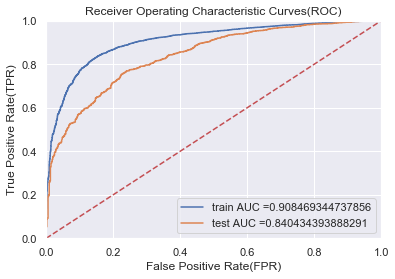

In [183]:
from sklearn.calibration import CalibratedClassifierCV
svm_tfidfavgw2v=SVC(C=10,gamma=0.01,class_weight='balanced',random_state=7,kernel='rbf')
svm_tfidfavgw2v.fit(X_train_tfidfavgw2v_std,y_train)

clf_sigmoid_tfidfavgw2v=CalibratedClassifierCV(svm_tfidfavgw2v,method='sigmoid',cv=3)
clf_sigmoid_tfidfavgw2v.fit(X_train_tfidfavgw2v_std,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  clf_sigmoid_tfidfavgw2v.predict_proba(X_train_tfidfavgw2v_std)[:,1]
y_cv_pred =  clf_sigmoid_tfidfavgw2v.predict_proba(X_cv_tfidfavgv2v_std)[:,1]
y_test_pred=clf_sigmoid_tfidfavgw2v.predict_proba(X_test_tfidfavgw2v_std)[:,1]

train_fpr, train_tpr, thresholds_tr_tfidfavgw2v = roc_curve(y_train, clf_sigmoid_tfidfavgw2v.predict_proba(X_train_tfidfavgw2v_std)[:,1])
test_fpr, test_tpr, thresholds_te_tfidfavgw2v = roc_curve(y_test, clf_sigmoid_tfidfavgw2v.predict_proba(X_test_tfidfavgw2v_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()



## Plotting confusion matrices using seaborn

In [184]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_tfidfavgw2v, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.7088155414539767 for threshold 0.783

Train confusion matrix:

[[1722  307]
 [1707 8650]]

Test confusion matrix:

[[ 407  158]
 [ 706 2600]]


In [185]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

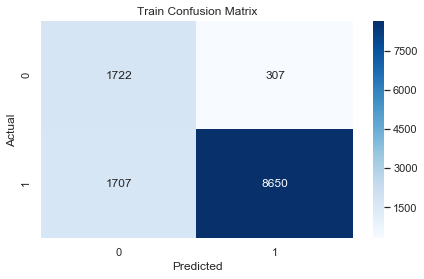

In [186]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

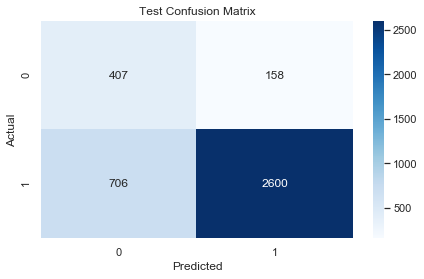

In [187]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

## Converting Train data to Tfidf_w2v :L2 regularization

In [157]:
model = TfidfVectorizer(norm='l2',min_df=2)
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [158]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 12386/12386 [01:26<00:00, 143.99it/s]


In [159]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

In [160]:
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

(12386, 50)
[ 0.11643651  0.39536964 -0.0530198   0.16290728  0.20536834  0.14692994
  0.24158337  0.05094466  0.19358289  0.52047954 -0.14585931  0.37150199
  0.35628069 -0.33740758 -0.01607318  0.19458248 -0.46884032 -0.19191344
  0.01676795 -0.27903894 -0.48430972  0.05530848 -0.51106722 -0.113332
  0.70294862 -0.18299098  0.03513861  0.58015667  0.62787731 -0.58307391
  0.13924072 -0.25950388  0.09647588  0.1116873   0.1284859  -0.10742175
 -0.16562855 -0.23564665  0.60271152  0.46148283  0.28018811  0.1443099
 -0.13898335 -0.06628986 -0.05424743 -0.56052057 -0.39265422  0.20409699
 -0.28245144 -0.30530048]


## Converting CV data to tfidf-w2v

In [161]:
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 3097/3097 [00:21<00:00, 144.99it/s]


In [162]:
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)

In [163]:
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

(3097, 50)
[ 2.86835735e-02  6.25643688e-02 -2.01316012e-01  4.15547875e-01
  5.27245098e-01  2.96048830e-01  3.77065890e-01 -8.53473769e-02
  3.35322017e-01  3.90092530e-01  1.42579404e-03  3.96980453e-01
  3.96202936e-01 -3.91842478e-01  9.14573741e-02 -2.71079298e-04
 -4.81939186e-01 -1.10106992e-01 -3.11308559e-01 -7.35095379e-01
 -6.10057446e-01 -2.66292755e-01 -4.73474201e-01 -3.78349735e-01
  6.06830822e-01 -3.76247307e-01  3.36215249e-01  8.18962534e-01
  5.11015868e-01 -4.02330560e-01 -1.48253234e-01 -5.24394526e-01
  4.00624950e-01  3.57901851e-01  1.43367787e-01 -7.66752963e-02
 -2.38684907e-01 -8.92449389e-02  7.37591458e-01  4.66622706e-01
  9.54773821e-02  1.35054988e-01  1.76156798e-01  1.14197967e-01
  2.95250708e-01 -5.69705591e-01 -4.45878273e-01  3.15291635e-01
 -4.92610181e-01 -1.98317685e-01]


## Converting Test data to tfidf-w2v

In [164]:

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 3871/3871 [00:29<00:00, 130.44it/s]


In [165]:
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

In [166]:
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

(3871, 50)
[ 0.04492012  0.21316705 -0.0805498   0.15639912  0.29786996  0.14676172
  0.27155098 -0.02393968  0.31856494  0.26794585 -0.07233571  0.4923222
  0.23294063 -0.44642958 -0.03451912  0.13422572 -0.2055286  -0.10559914
  0.00923976 -0.33637306 -0.50468453 -0.05774854 -0.57717958 -0.13493992
  0.55134049 -0.43052366 -0.10191325  0.60846588  0.46457978 -0.33302172
 -0.08674506 -0.36480126  0.10138137  0.13168604 -0.04264327 -0.15357452
 -0.04109781 -0.25703109  0.56767145  0.52045058  0.29124309  0.08683082
 -0.08734742  0.16191754 -0.06495702 -0.47813171 -0.38656445  0.04897871
 -0.27700017 -0.28389473]


In [167]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
# Assigning values to the parameters
C=[10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
Gamma=[10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
params_grid=dict(C=C,gamma=Gamma)

In [168]:
# Estimator
svm=SVC(kernel='rbf',class_weight='balanced',random_state=8)

In [169]:
# Building RandomizedsSearchCV

svm_RandomCV_l2=RandomizedSearchCV(svm,params_grid,cv=5,scoring='roc_auc',n_jobs=-1)
svm_RandomCV_l2.fit(tfidf_sent_vectors_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=8, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                              100, 1000],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100, 1000]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=0)

In [170]:
## Finding best parameters
svm_RandomCV_l2.best_params_

{'gamma': 0.01, 'C': 1000}

In [171]:
## Finding best score
svm_RandomCV_l2.best_score_

0.8627821278595014

## Building svm with best hyperparameters

In [172]:
# Standardizing the data
sc=StandardScaler(with_mean=False)
X_train_tfidfavgw2v_std=sc.fit_transform(tfidf_sent_vectors_train)
X_cv_tfidfavgv2v_std=sc.transform(tfidf_sent_vectors_cv)
X_test_tfidfavgw2v_std=sc.transform(tfidf_sent_vectors_test)

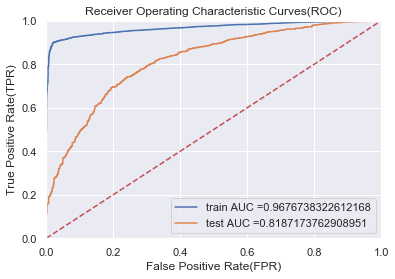

In [173]:
from sklearn.calibration import CalibratedClassifierCV
svm_tfidfavgw2v=SVC(C=1000,gamma=0.01,class_weight='balanced',random_state=8,kernel='rbf')
svm_tfidfavgw2v.fit(X_train_tfidfavgw2v_std,y_train)

clf_sigmoid_tfidfavgw2v=CalibratedClassifierCV(svm_tfidfavgw2v,method='sigmoid',cv=3)
clf_sigmoid_tfidfavgw2v.fit(X_train_tfidfavgw2v_std,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  clf_sigmoid_tfidfavgw2v.predict_proba(X_train_tfidfavgw2v_std)[:,1]
y_cv_pred =  clf_sigmoid_tfidfavgw2v.predict_proba(X_cv_tfidfavgv2v_std)[:,1]
y_test_pred=clf_sigmoid_tfidfavgw2v.predict_proba(X_test_tfidfavgw2v_std)[:,1]

train_fpr, train_tpr, thresholds_tr_tfidfavgw2v = roc_curve(y_train, clf_sigmoid_tfidfavgw2v.predict_proba(X_train_tfidfavgw2v_std)[:,1])
test_fpr, test_tpr, thresholds_te_tfidfavgw2v = roc_curve(y_test, clf_sigmoid_tfidfavgw2v.predict_proba(X_test_tfidfavgw2v_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()



In [174]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_tfidfavgw2v, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.8811572737928216 for threshold 0.754

Train confusion matrix:

[[1990   39]
 [1052 9305]]

Test confusion matrix:

[[ 376  189]
 [ 594 2712]]


In [175]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

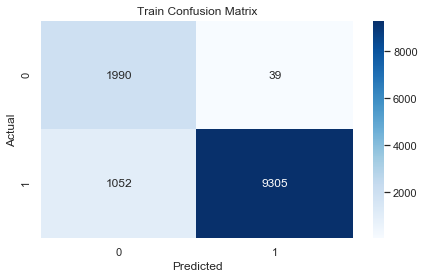

In [176]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

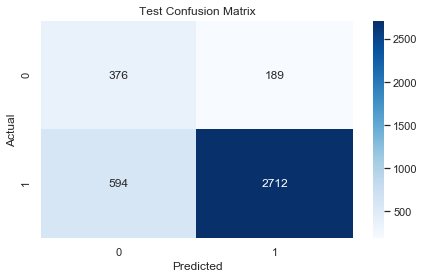

In [177]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

# Conclusions

In [188]:
## Conclusions for Linear SVM

In [189]:
from prettytable import PrettyTable

In [190]:
x=PrettyTable()

In [191]:
x.field_names=['Vectorizer','Regularization','Hyper Parameter_alpha','AUC']

In [192]:
x.add_row(['BOW','L1',10**-4,0.8690*100])
x.add_row(['BOW','L2',10**-3,0.8456*100])
x.add_row(['TFIDF','L1',10**-4,0.9053*100])
x.add_row(['TFIDF','L2',10**-4,0.9105*100])
x.add_row(['AVGW2V','L1',10**-4,0.8875*100])
x.add_row(['AVGW2V','L2',10**-3,0.8875*100])
x.add_row(['TFIDF_AVGW2V','L1',10**-4,0.8652*100])
x.add_row(['TFIDF_AVGW2V','L2',10**-3,0.8162*100])

In [193]:
print(x)

+--------------+----------------+-----------------------+-------+
|  Vectorizer  | Regularization | Hyper Parameter_alpha |  AUC  |
+--------------+----------------+-----------------------+-------+
|     BOW      |       L1       |         0.0001        |  86.9 |
|     BOW      |       L2       |         0.001         | 84.56 |
|    TFIDF     |       L1       |         0.0001        | 90.53 |
|    TFIDF     |       L2       |         0.0001        | 91.05 |
|    AVGW2V    |       L1       |         0.0001        | 88.75 |
|    AVGW2V    |       L2       |         0.001         | 88.75 |
| TFIDF_AVGW2V |       L1       |         0.0001        | 86.52 |
| TFIDF_AVGW2V |       L2       |         0.001         | 81.62 |
+--------------+----------------+-----------------------+-------+


In [199]:
## Conclusions for rbf SVM

In [200]:
x=PrettyTable()

In [201]:
x.field_names=['Vectorizer','Regularization','Hyper Parameter_C','Hyper Parameter_gamma','AUC']

In [202]:
x.add_row(['BOW','-',100,0.0001,0.8486*100])
x.add_row(['TFIDF','L1',10,10,0.8659*100])
x.add_row(['TFIDF','L2',1,1,0.8792*100])
x.add_row(['AVGW2V','-',100,0.01,0.8534*100])
x.add_row(['TFIDF_AVGW2V','L1',10,0.01,0.8404*100])
x.add_row(['TFIDF_AVGW2V','L2',1000,0.01,0.8187*100])

In [203]:
print(x)

+--------------+----------------+-------------------+-----------------------+-------+
|  Vectorizer  | Regularization | Hyper Parameter_C | Hyper Parameter_gamma |  AUC  |
+--------------+----------------+-------------------+-----------------------+-------+
|     BOW      |       -        |        100        |         0.0001        | 84.86 |
|    TFIDF     |       L1       |         10        |           10          | 86.59 |
|    TFIDF     |       L2       |         1         |           1           | 87.92 |
|    AVGW2V    |       -        |        100        |          0.01         | 85.34 |
| TFIDF_AVGW2V |       L1       |         10        |          0.01         | 84.04 |
| TFIDF_AVGW2V |       L2       |        1000       |          0.01         | 81.87 |
+--------------+----------------+-------------------+-----------------------+-------+
